In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [5]:
def dados_tendencia_agricultura():    
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7", "municipality":"NOME"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2", "NOME"])[list(range(1985, 2023))].sum().reset_index()
    biomas_agrupados_cidade = biomas_agrupados[biomas_agrupados["level_2"] == "Agriculture"]
    serie_agricultura = biomas_agrupados_cidade.melt(id_vars=["IBGE7", "level_2", "NOME"], 
                             var_name="ANO", 
                             value_name="AREA_AGRICULTURA")
    serie_agricultura
    return serie_agricultura

def plot_tendencia(dados_tendencia):
    nome = dados_tendencia["NOME"].values[0]
    dados_tendencia.plot(kind="line", x="ANO", y="AREA_AGRICULTURA", color="g")
    plt.title(f"Dinâmica da área da agricultura em {nome}")
    plt.ylabel("Área de agricultura (Ha)");



def dados_para_stacked_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                          sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "municipality", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2"])[list(range(1985, 2023))].sum().reset_index()
    
    biomas_lista = ["Forest Formation", "Mosaic of Agriculture and Pasture", "Pasture", "Savanna Formation"]
    lista_Anos = list(range(2010, 2022))
    biomas_serem_explorados = biomas_agrupados[biomas_agrupados["level_2"].isin(biomas_lista)]
    biomas_serem_explorados = biomas_serem_explorados.melt(id_vars=["IBGE7", "level_2"], var_name="ANO", value_name="AREA_HECTAR")
    biomas_serem_explorados = biomas_serem_explorados[biomas_serem_explorados["ANO"].isin(lista_Anos)]
    return biomas_serem_explorados


def plot_stacked_bar(biomas_serem_explorados):
    pivot_df = biomas_serem_explorados.drop(columns="IBGE7").pivot(index='ANO', columns='level_2', values='AREA_HECTAR')
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    ax = pivot_df_percent.plot(kind='bar', stacked=True, figsize=(20, 10))
    sns.set_style(None)
    ax.set_xlabel(None)
    plt.ylabel('% de área')
    plt.xticks(rotation=0)
    plt.title('Distribuição das coberturas mais indicadas para transição para Agricultura')
    plt.show()



def dados_para_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                      sheet_name="TRANSICOES_COL8.0")
    biomas_municipais = biomas_municipais[["geocode", "state_acronym", "from_level_2", "to_level_2", "1985-2022"]]
    biomas_municipais.rename(columns={"geocode":"IBGE7", "state_acronym":"UF"}, inplace=True)
    condicao_agricultura = (biomas_municipais["to_level_2"].isin(["Agriculture", "Mosaic of Agriculture and Pasture"]))
    biomas_municipais = biomas_municipais[condicao_agricultura].reset_index(drop=True)
    biomas_municipais_melted = biomas_municipais.melt(id_vars=["UF","IBGE7", "to_level_2", "from_level_2"], 
                                                            value_name="AREA_TRANSICAO",
                                                            value_vars="1985-2022")
    agrupado = biomas_municipais_melted.groupby(by=["UF", "IBGE7", "from_level_2"])[["AREA_TRANSICAO"]].sum()
    agrupado["AREA_TRANSICAO_MEDIA_ANUAL"] = agrupado["AREA_TRANSICAO"] / 38
    dados_biomas = agrupado.reset_index().sort_values(by=["IBGE7", "AREA_TRANSICAO_MEDIA_ANUAL"], ascending=[True, False])
    return dados_biomas

## 1) Carregando dados

In [6]:
dados_tendencia = dados_tendencia_agricultura()
df_barplot = dados_para_plot()
dados_stacked = dados_para_stacked_plot()

In [11]:
codigo_itapicuru = 2916500

## 2) Análse de Agrocultura em Itapicuru

### 2.1) Tendência de crescimento da agrcultura

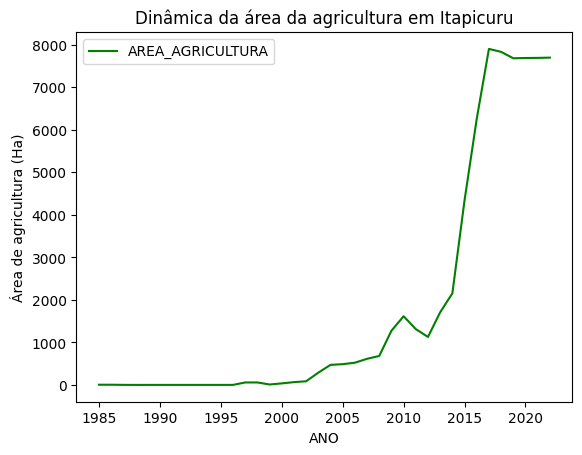

In [12]:
dados_tendencia = dados_tendencia[dados_tendencia["IBGE7"] == codigo_itapicuru]
plot_tendencia(dados_tendencia)

Podemos perceber que a área agrícola no município de Itapicuru vem crescendo de maneira exponecial.

### 2.2) Disponibilidade de áreas de cada bioma ao longo dos anos

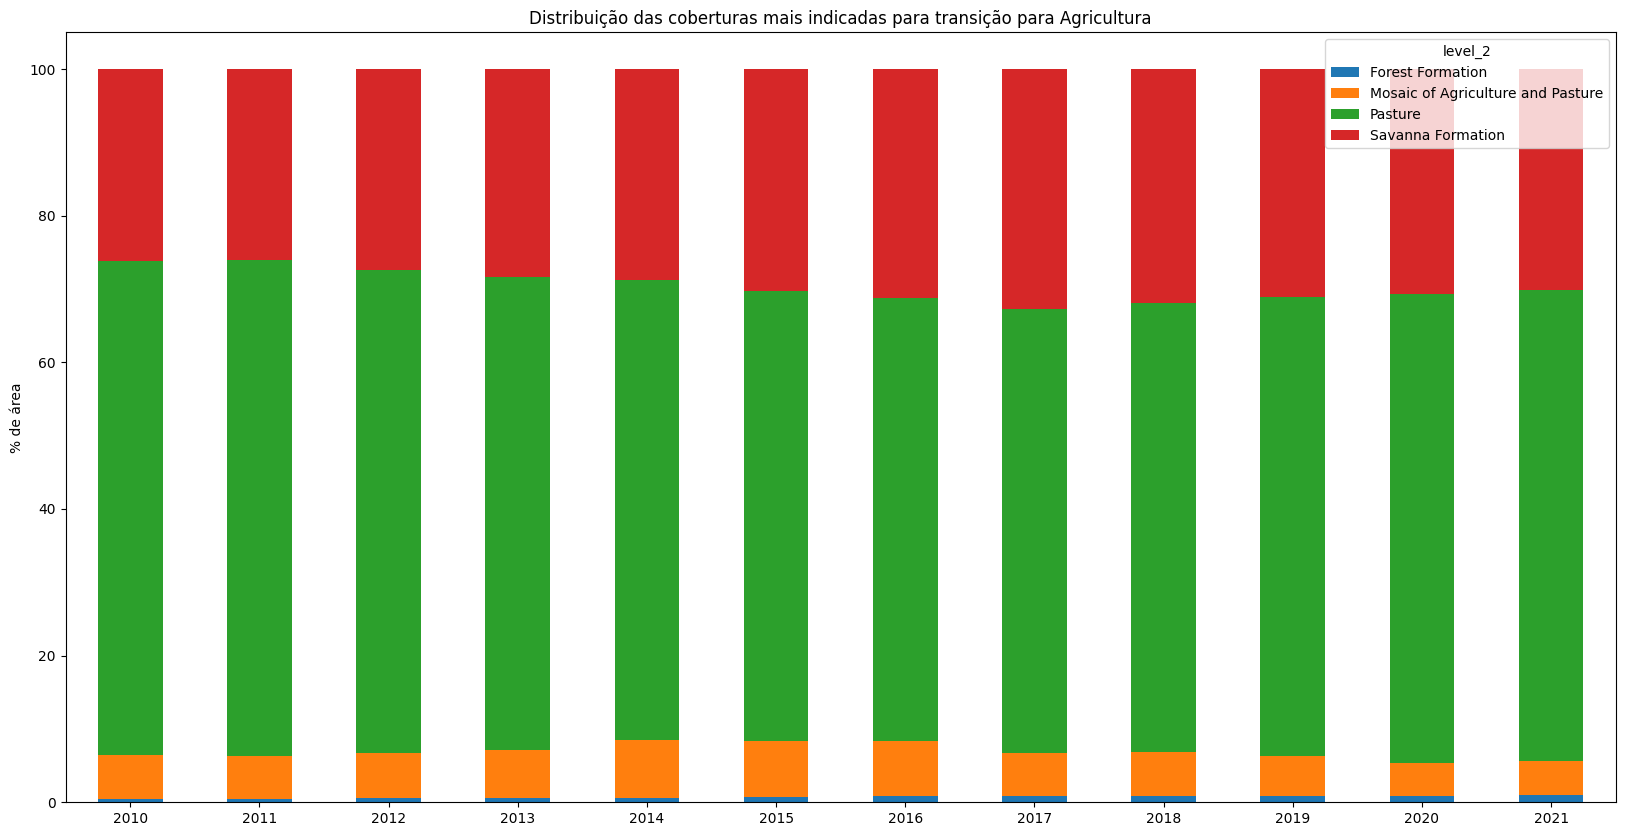

In [13]:
plot_stacked_bar(dados_stacked[dados_stacked["IBGE7"] == codigo_itapicuru])

Pode-se perceber que a disponibilidade de terreno com bioma de Pasto e Savana se sobressaem com relação a outros biomas. Além disso, o bioma de Savana vem crescendo ao longo dos anos.

### 2.3) Transição média anual de transição de cada bioma em área agrícola

O gráfico abaixo mostra a quantidade média anual de área na qual um bioma transiciona para uma cobertura de agricultura. Podemos perceber que o Pasto é o bioma que mais transiciona, embora já esteja sofrendo ação antrópica. Com relação aos biomas que não sofrem ação antrópica, as formações de Savana se sobressaem enquanto que logo abaixo se encontram as formações de Floresta.

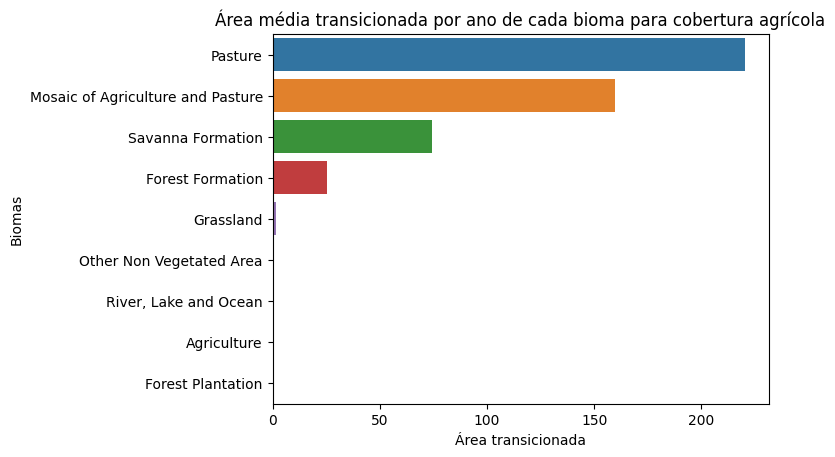

In [15]:
df_barplot = df_barplot[df_barplot["IBGE7"] == codigo_itapicuru]
sns.barplot(df_barplot, y="from_level_2", x="AREA_TRANSICAO_MEDIA_ANUAL")
plt.xlabel("Área transicionada")
plt.ylabel("Biomas")
plt.title("Área média transicionada por ano de cada bioma para cobertura agrícola")
plt.show()

Conclusão
- Portanto, como há um crescente nas áreas agrícolas e, as distribuições de biomas que mais existem na região de Itapicuru são também os biomas que mais transicionam para a Agricultura, é evidente que há espaço para crescimento dado, que a cobertura que não foi afetada pela ação do homem vem crescendo em exensão e ela, também é uma das que mais está ápta para exploração da agicultura.

Neste link do Power BI, se encontra um dashboad com os gráficos mais interessantes filtrados por municípios:
https://app.powerbi.com/view?r=eyJrIjoiYzIyZmE1MWMtYzRmMi00NDBlLWExZDEtM2Q2MWI5ZjdlOGNhIiwidCI6IjQwZDc5YzUxLWFkYzAtNDliNC04YWRiLTM1NjE2YzUzMTc2YiJ9